In [2]:
import pandas as pd
import numpy as np
import rapid_review as rr
import os
import matplotlib.pyplot as plt
import importlib
from sklearn.svm import SVC, OneClassSVM
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier

In [68]:
importlib.reload(rr)

dfs = []
for path in [("ProtonBeam","all"),("COPD","copd")]:
    document_index = rr.parse_pb_xml(f'../data/{path[0]}/{path[1]}.xml')
    document_index = document_index.drop_duplicates()
    document_index['rec-number'] = document_index['rec-number'].astype(int)
    
    relevant_index = pd.read_csv(
    f'../data/{path[0]}/relevant.txt',header=None,
    names=["rec-number"])
    
    relevant_index['relevant'] = 1
    
    df = pd.merge(
        document_index,
        relevant_index,
        how="left"
    )
    
    df['review'] = path[0]
    dfs.append(df)
    
df = pd.concat(dfs)
df['relevant'] = df['relevant'].fillna(0)    
df.head()

,ab,rec-number,ti,relevant,review
0,None,2201,Proton radiation for acromegaly,0.0,ProtonBeam
1,Particle radiation therapy has the potential f...,2202,Particle radiation therapy,0.0,ProtonBeam
2,The Program for Particle Therapy proposes util...,2203,Proposal for a program in particle-beam radiat...,0.0,ProtonBeam
3,None,2204,[Congress on linear accelerators: radioprotect...,0.0,ProtonBeam
4,None,2205,Particle accelerators in radiation therapy. Pr...,0.0,ProtonBeam


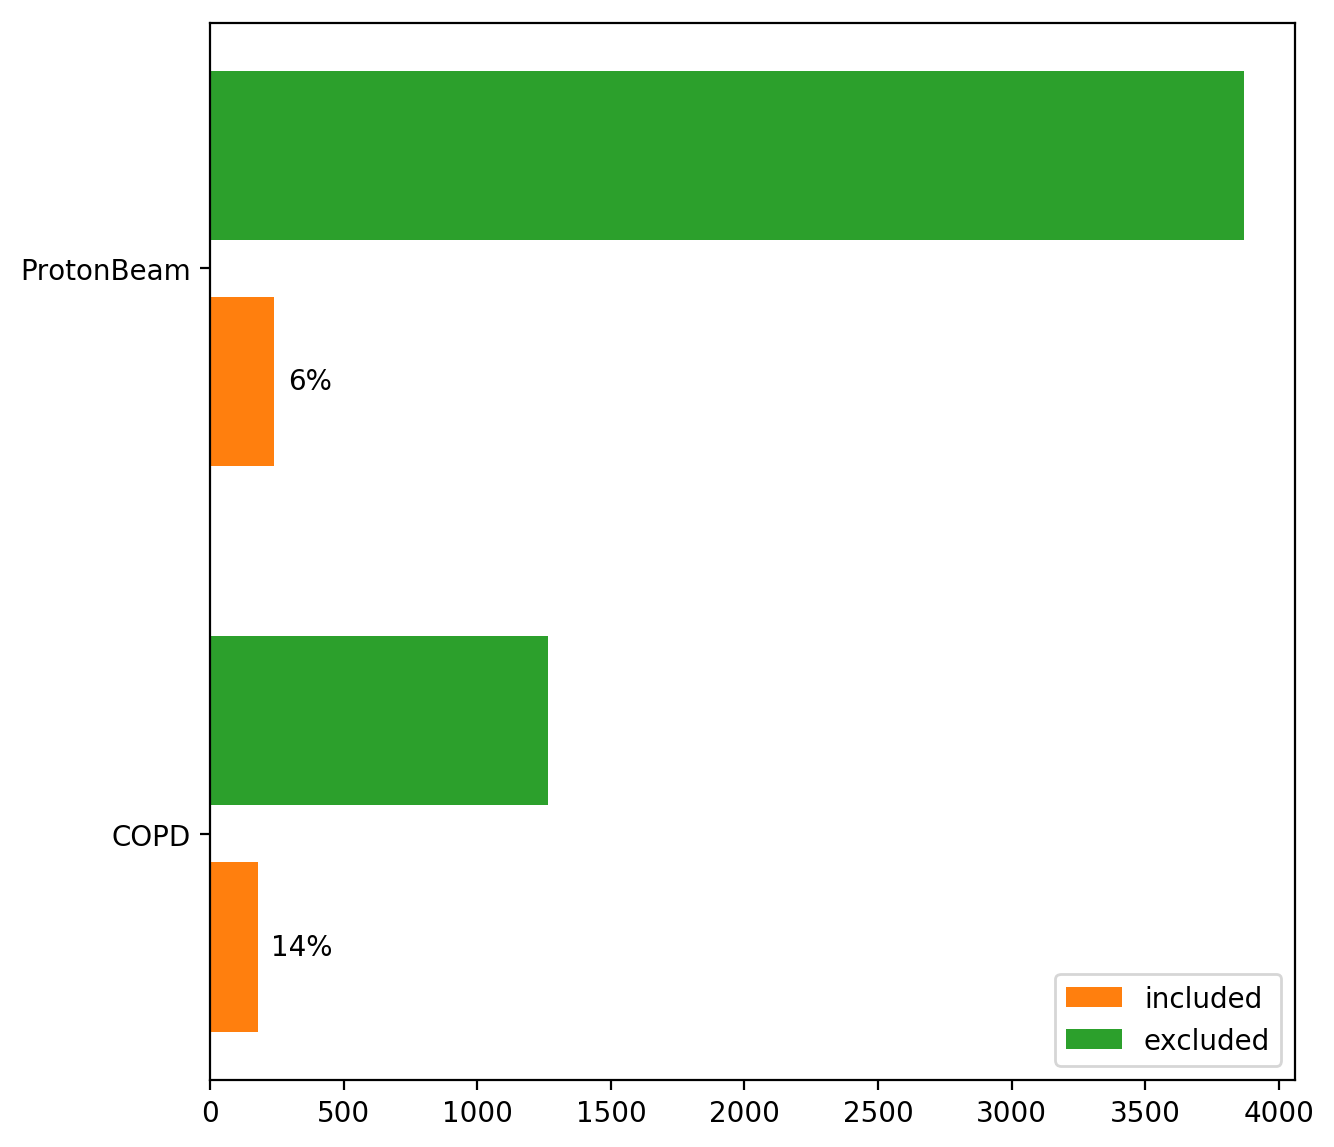

In [69]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)

cm = plt.cm.RdYlBu


ticklabels = []
for i, (name, group) in enumerate(df.groupby('review')):
    if i==0:
        l1="included"
        l2="excluded"
    else:
        l1 = None
        l2 = None
        
    group = group.dropna()
    included = group[group['relevant']==1].shape[0]
    excluded = group[group['relevant']==0].shape[0]
    ax.barh(i-0.2, included, height=0.3, color='C1',label=l1)
    ax.barh(i+0.2, excluded, height=0.3, color='C2', label=l2)
    ax.text(included+50, i-0.2, f'{included/excluded:.0%}', ha="left", va="center")
    ticklabels.append(name)
        
ax.set_yticks([i for i,v in enumerate(ticklabels)])
ax.set_yticklabels(ticklabels)

ax.legend()
    
    
plt.show()

In [52]:
group

,ab,rec-number,ti,relevant,review


[Text(0, 0, '0.0'), Text(0, 0, '1.0')]

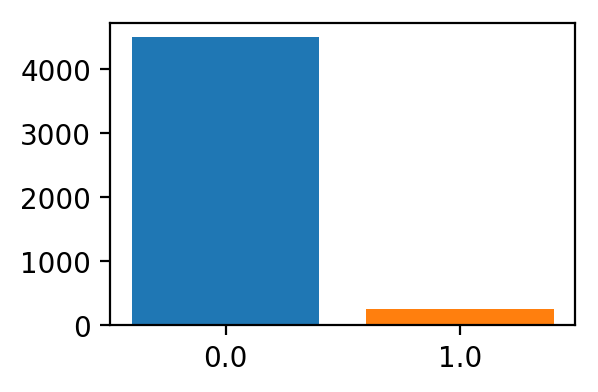

In [27]:
fig, ax = plt.subplots(figsize=(3,2),dpi=200)

ticks = []
labels = []
for i, (name, group) in enumerate(df.groupby('relevant')):
    ax.bar(i, group.shape[0])
    ticks.append(i)
    labels.append(name)
    
ax.set_xticks(ticks)
ax.set_xticklabels(labels)

In [71]:
importlib.reload(rr)

results = []
iterations = 1

df['x'] = df['ab']

for name, group in df.groupby('review'):
    group = group.dropna().reset_index(drop=True)

    if name != "COPD":
        continue
    models = [
        SVC(kernel='linear',class_weight='balanced',probability=True)
        #MultinomialNB(alpha=0.1)    
        #MLPClassifier(
        #    solver='lbfgs', 
        #    alpha=0.1,
        #    hidden_layer_sizes=(10), 
        #    random_state=1
        #)
    ]

    ss = rr.ScreenScenario(
        group, models, 300, [50,100,200], name
    )
    for i in range(iterations):
        results.append(ss.screen(i, True))

Dataset: COPD, iteration 0.  1443 out of 1443 documents seen (100%) - recall: 100%


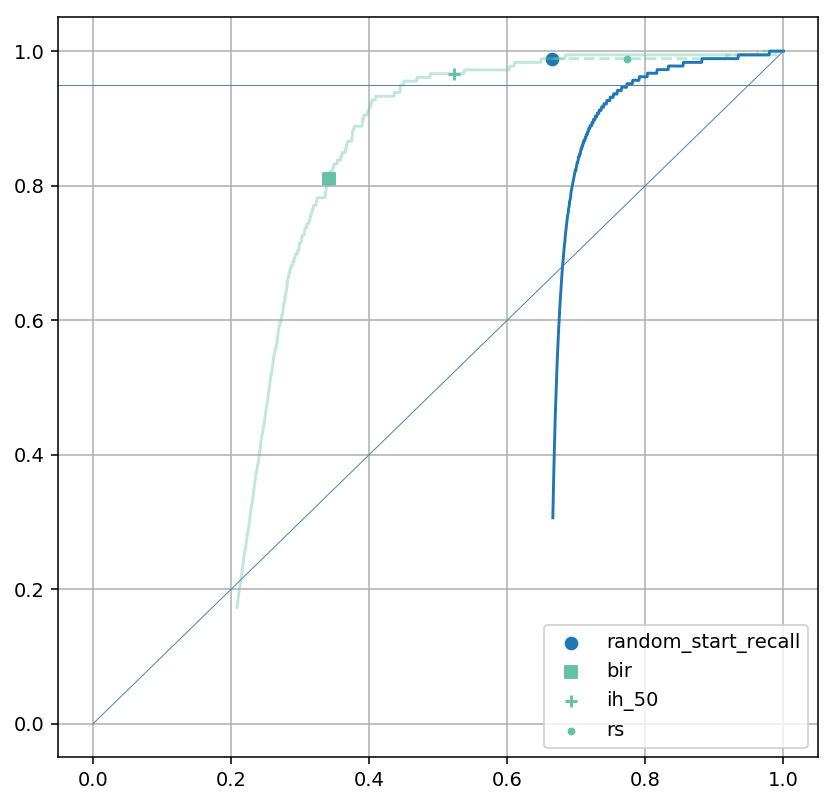

In [72]:
results_df = pd.DataFrame.from_dict(results)

fig, ax = plt.subplots(figsize=(7,7),dpi=140)
colors = ['#66c2a5','#fc8d62','#8da0cb']

a = 0.4

pdf = results_df[results_df['N'] > 1000]

for i, p in pdf.iterrows():

    ax.plot(p['work_track'], p['recall_track'], c = colors[0], alpha=a)
    ax.plot(p['random_work_track'], p['random_recall_track'], c = colors[0], alpha=a, linestyle="--")
    ax.plot(p['random_work_track'], p['estimated_recall_path'])
    
s_crit = ["bir","ih_50","rs"]

import itertools
marker = itertools.cycle((',', '+', '.', 'o', '*')) 

ax.scatter(pdf['random_start_work'],pdf['random_start_recall'])

for s in s_crit:
    ax.scatter(
        1- pdf[f'wss95_{s}'], 
        pdf[f'recall_{s}'], 
        c = colors[0], marker = next(marker),
        label = s
    )
    
ax.axhline(0.95, color="steelblue",lw=0.5)
ax.plot([0,1],[0,1], color="steelblue", lw=0.5)
ax.legend()
ax.grid()

plt.show()